In [ ]:
#Dataanalys


In [ ]:
#Libraries
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

#fetch dataset
from FeGdSpinGNN.FeGd_dataset import FeGdMagneticDataset
from FeGdSpinGNN_NonEqui.common.utils import plot_systems_3d, plot_spin_B_histograms

In [41]:
#Load the data of one system, plot it and check its properties.

dataset = FeGdMagneticDataset(
        root=r'FeGd',
        systems=[2, 3, 4, 5, 6],
        cutoff_dist=0.3,  
        use_static_features=False,  
    )

Loading systems: 100%|██████████| 5/5 [00:18<00:00,  3.70s/it]


In [4]:
print(dataset[0])

Data(x=[800, 5], edge_index=[2, 9168], edge_attr=[9168, 4], y=[800, 3], pos=[800, 3], system_id=2, timestep=0)


In [42]:
plot_systems_3d(dataset, systems=[2], show_edges=False)

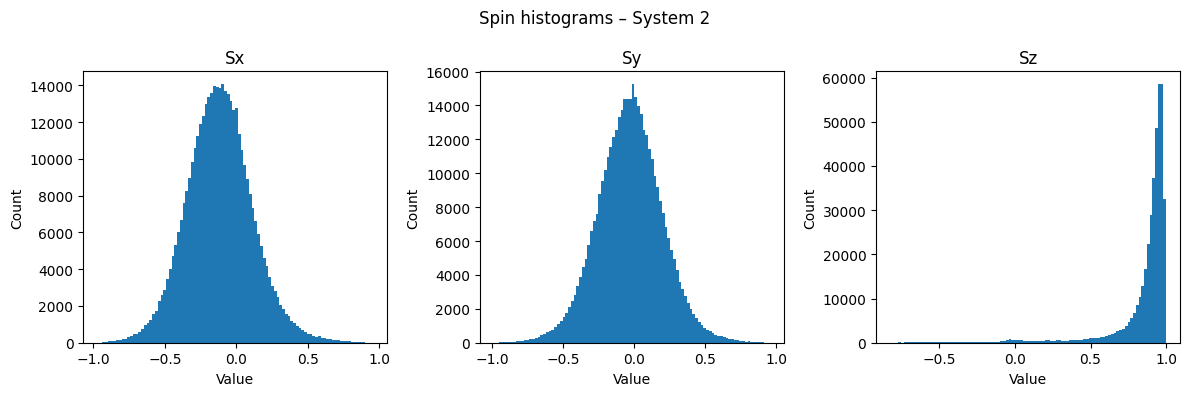

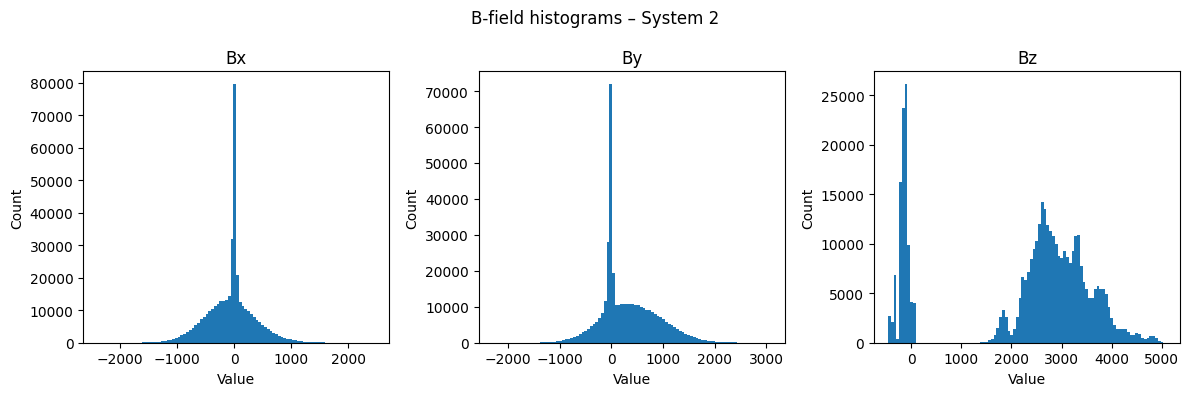

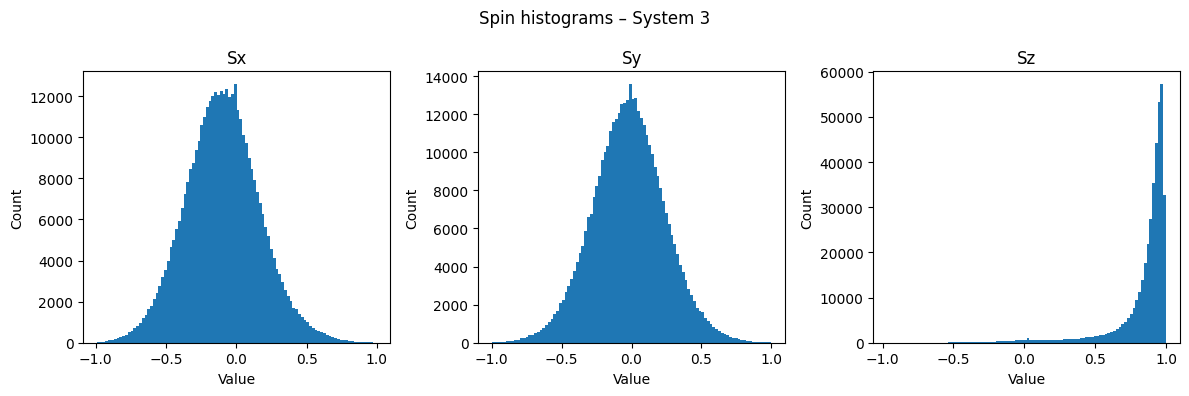

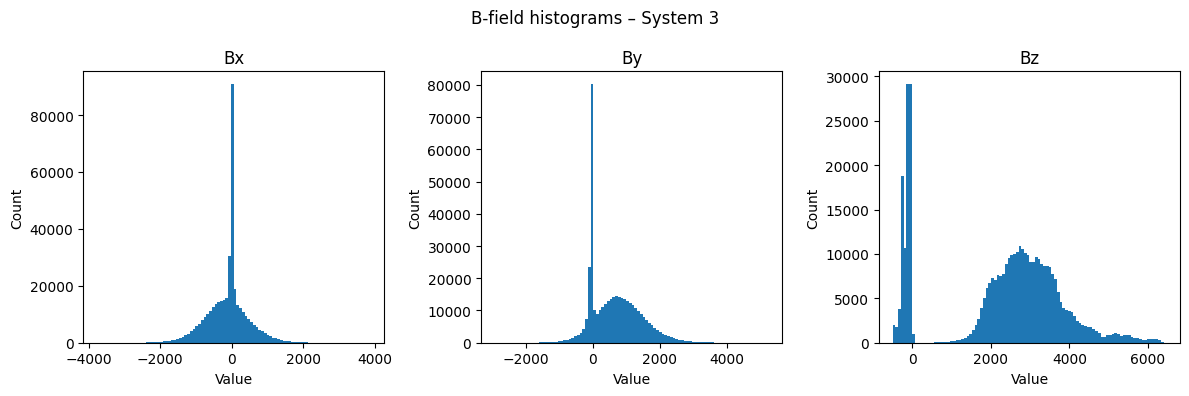

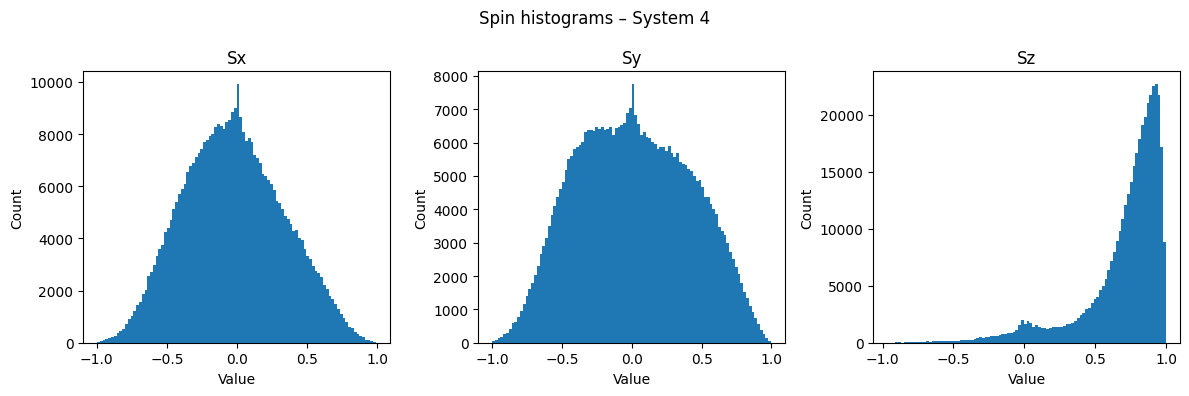

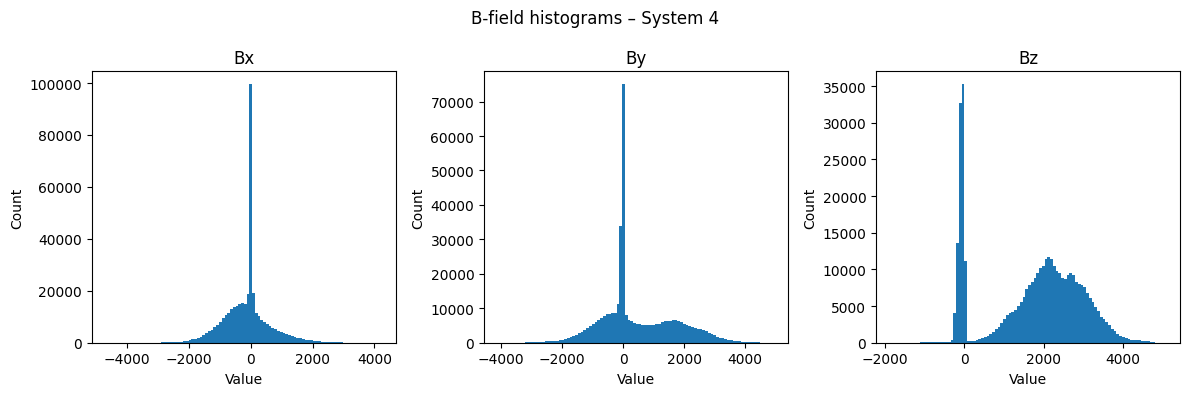

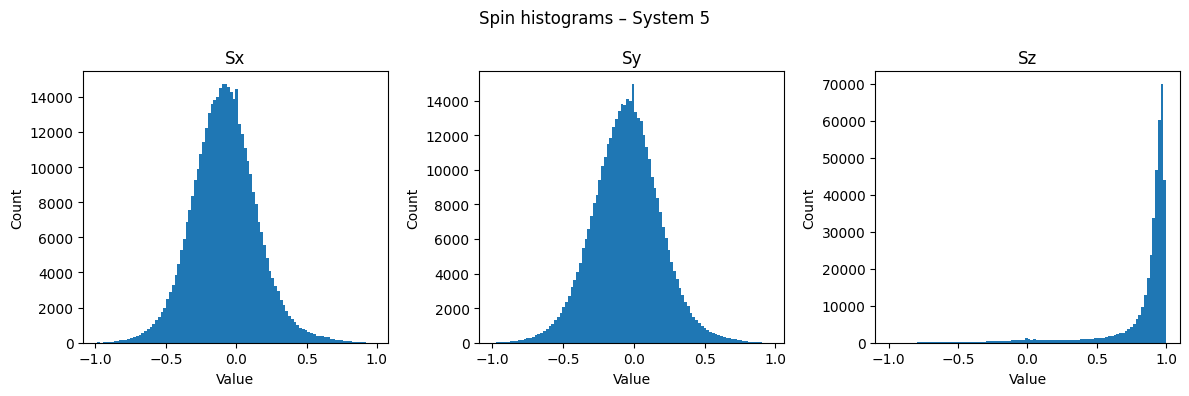

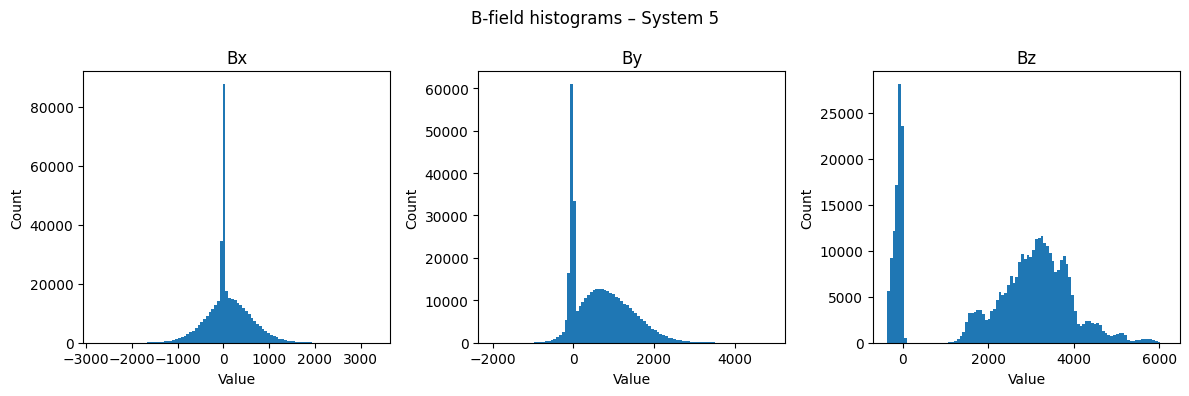

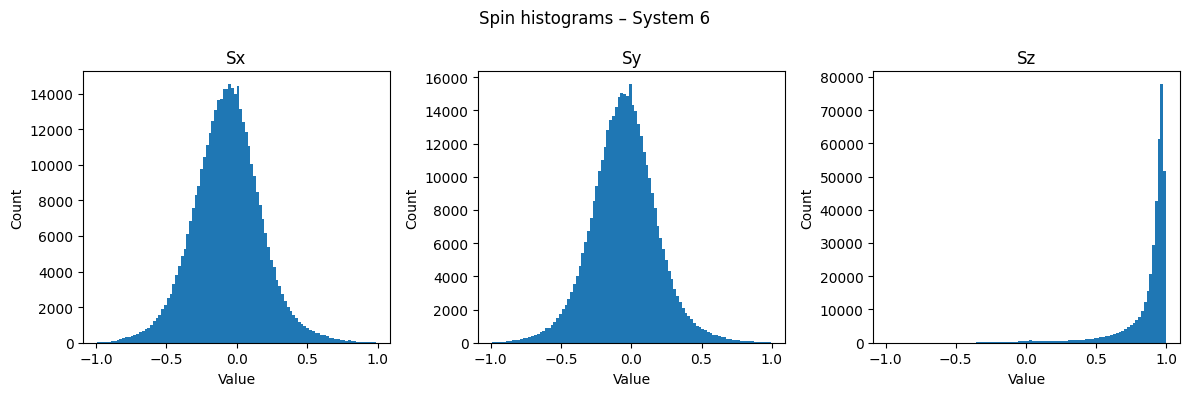

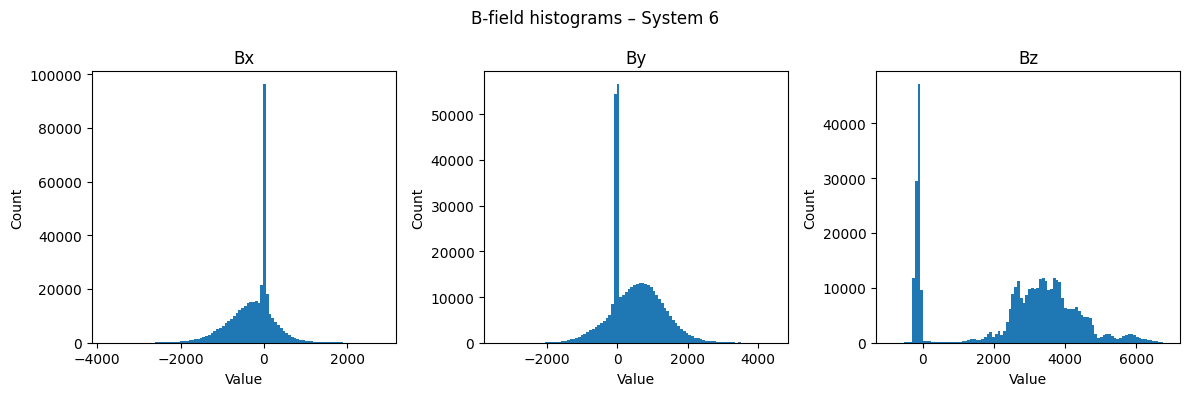

In [44]:
plot_spin_B_histograms(dataset, systems=[2, 3, 4, 5, 6], bins=100)

In [24]:
from FeGdSpinGNN.utils import compute_normalization_stats, normalize_data

stats = compute_normalization_stats(dataset)
dataset_normalized = [normalize_data(data, stats) for data in dataset]

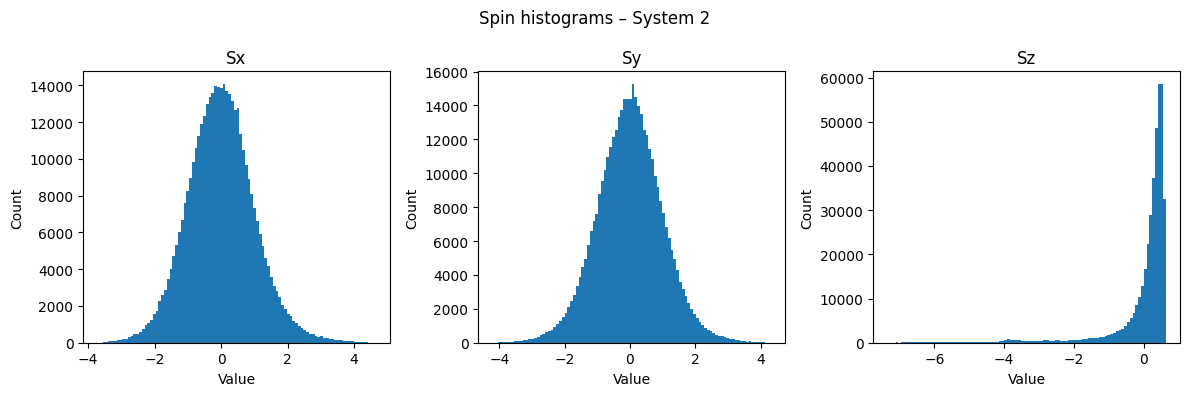

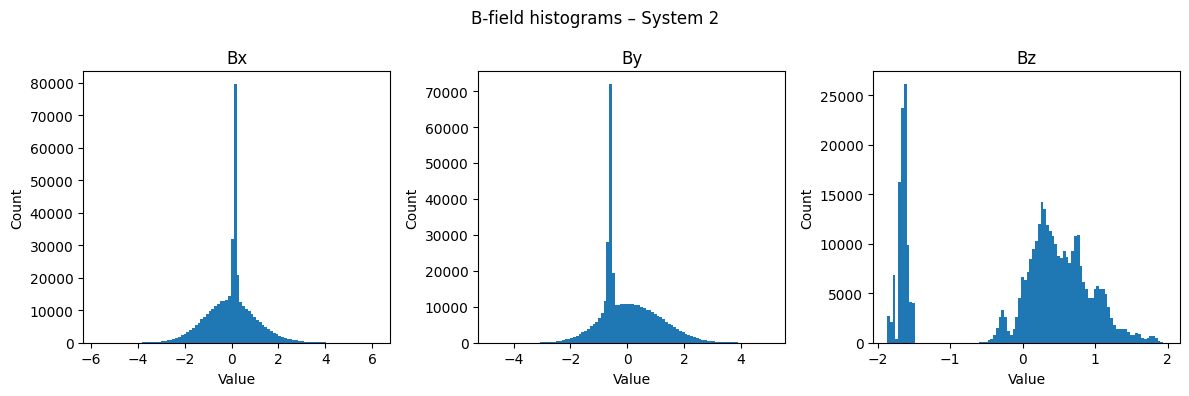

In [25]:
plot_spin_B_histograms(dataset_normalized, systems=[2], bins=100)

In [32]:
import torch
import numpy as np


# ---------- STATS ----------

def compute_normalization_stats(dataset):
    """
    Spins (x[:,2:5]) -> mean/std
    B-field (y)      -> log-magnitude + mean/std
    """
    # collect over whole dataset
    all_spins = torch.cat([d.x[:, 2:5] for d in dataset], dim=0)   # [N,3]
    all_B     = torch.cat([d.y          for d in dataset], dim=0)  # [N,3]

    # spins: normal standardization
    moment_mean = all_spins.mean(dim=0)
    moment_std  = all_spins.std(dim=0).clamp(min=1e-6)

    # B: log-magnitude transform for each component separately
    B_abs = all_B.abs()
    # scale parameter ~ typical magnitude
    B_s0  = torch.quantile(B_abs, 0.5, dim=0)  # median |B|
    B_s0  = B_s0.clamp(min=1.0)                # avoid tiny scale

    B_log = all_B.sign() * torch.log1p(B_abs / B_s0)

    B_log_mean = B_log.mean(dim=0)
    B_log_std  = B_log.std(dim=0).clamp(min=1e-6)

    stats = {
        "moment_mean": moment_mean,
        "moment_std":  moment_std,
        "B_s0":        B_s0,
        "B_log_mean":  B_log_mean,
        "B_log_std":   B_log_std,
    }
    return stats


# ---------- NORMALIZE ONE GRAPH ----------

def normalize_graph(data, stats):
    """
    Return a normalized copy of a PyG Data object.
    Spins: (x[:,2:5] - mean) / std
    B:     sign(B)*log1p(|B|/s0), then standardize
    """
    d = data.clone()

    # spins
    d.x[:, 2:5] = (d.x[:, 2:5] - stats["moment_mean"]) / stats["moment_std"]

    # B -> log space
    B     = d.y
    B_s0  = stats["B_s0"].to(B.device)
    B_abs = B.abs()
    B_log = B.sign() * torch.log1p(B_abs / B_s0)

    # standardize log-B
    B_log_mean = stats["B_log_mean"].to(B.device)
    B_log_std  = stats["B_log_std"].to(B.device)
    d.y = (B_log - B_log_mean) / B_log_std

    return d


# ---------- NORMALIZE DATASET ----------

def normalize_dataset(dataset, stats):
    return [normalize_graph(d, stats) for d in dataset]


In [33]:
stats = compute_normalization_stats(dataset)
dataset_norm = normalize_dataset(dataset, stats)

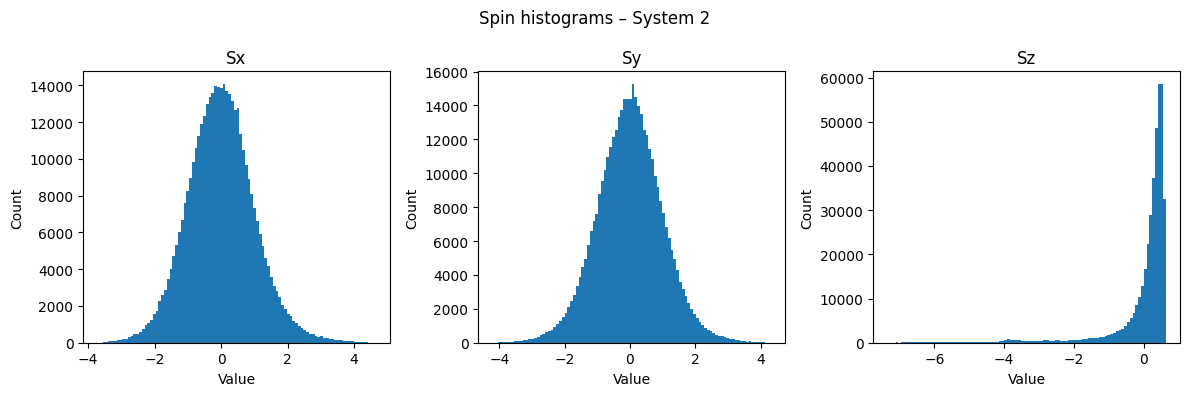

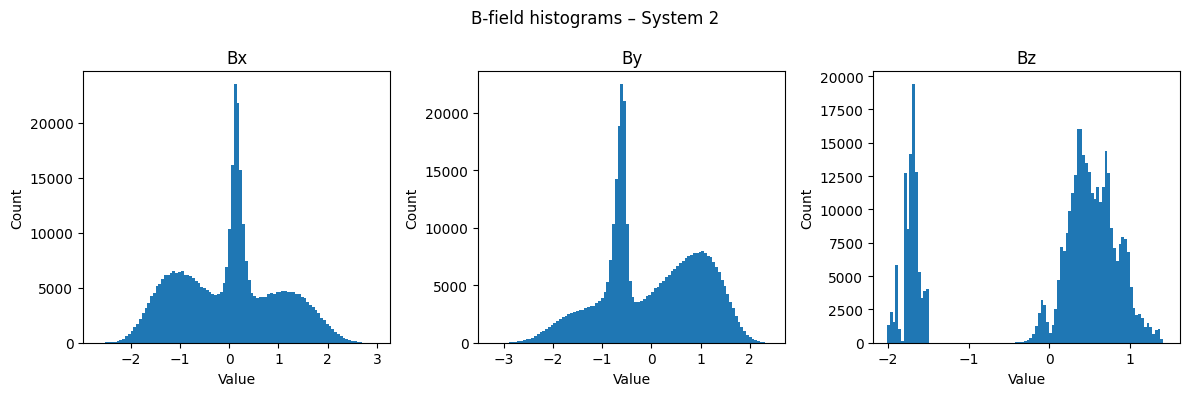

In [34]:
plot_spin_B_histograms(dataset_norm, systems=[2], bins=100)

In [35]:
def denormalize_B(y_norm, stats, device="cpu"):
    B_s0       = stats["B_s0"].to(device)
    B_log_mean = stats["B_log_mean"].to(device)
    B_log_std  = stats["B_log_std"].to(device)

    B_log = y_norm * B_log_std + B_log_mean
    # invert sign*log1p(|B|/s0)
    return B_log.sign() * (torch.expm1(B_log.abs()) * B_s0)


In [40]:
# If i would predict mean on the data only, how well MAE would that give?
all_B = torch.cat([d.y for d in dataset_norm], dim=0)
mean_B = all_B.mean(dim=0)
mae = torch.mean(torch.abs(all_B - mean_B), dim=0)
zero_predict = torch.zeros_like(all_B)
mae_zero = torch.mean(torch.abs(all_B - zero_predict), dim=0)
print("Zero B-field MAE per component:", mae_zero.numpy())
print("Mean B-field MAE per component:", mae.numpy())





Zero B-field MAE per component: [0.8043772  0.86488515 0.8293396 ]
Mean B-field MAE per component: [0.8043772  0.86488515 0.8293396 ]
